vintage.ts already downloaded
percussion.ts already downloaded
VCTK.ts already downloaded


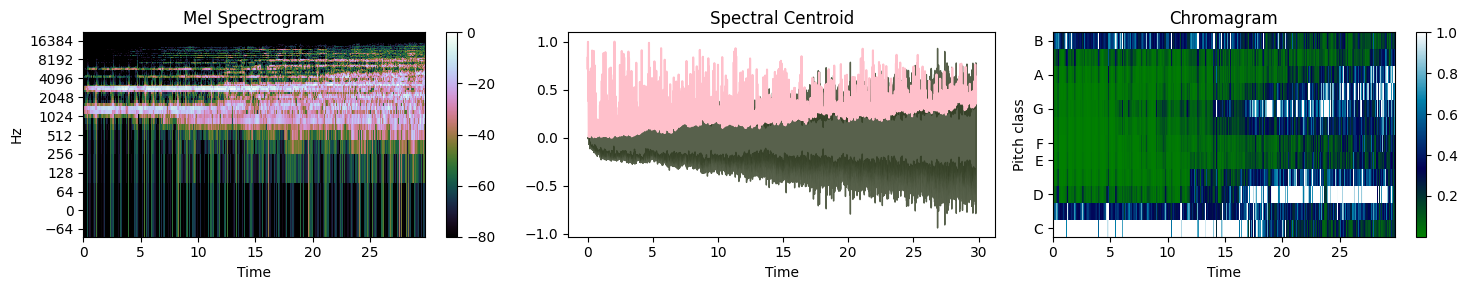

Audio saved to generated/generated_audio.wav


In [5]:
import os
import wget
import torch
import numpy as np
import IPython.display as ipd
import soundfile as sf
import librosa
import librosa.display
import matplotlib.pyplot as plt
import sklearn.preprocessing  
from src.latent_util import create_latent_interp, clamp

#set the dimensionality of the latent space and the sample rate
latent_dim = 8
sample_rate = 44100
#as style transfer is to be performed later, audio needs to be generated to match the length of the content audio(30 seconds)
total_duration_seconds = 330 

#folder where pretrained models will be downloaded
pt_path = "rave_models"
#create the folder if it doesn't exist
if not os.path.exists(pt_path):
    os.mkdir(pt_path)

#list of available pretrained_models to download in https://acids-ircam.github.io/rave_models_download (you can select less if you want to spend less time on this cell)
pretrained_models = ["vintage", "percussion", "VCTK"]

#download pretrained models and save them in pt_path
for model in pretrained_models:
    model_path = os.path.join(pt_path, f"{model}.ts")
    if not os.path.exists(model_path):
        print(f"Downloading {model}.ts...")
        wget.download(f"https://play.forum.ircam.fr/rave-vst-api/get_model/{model}", model_path)
    else:
        print(f"{model}.ts already downloaded")

#folder where generated audio will be saved
generated_path = "generated"
#create the folder if it doesn't exist
if not os.path.exists(generated_path):
    os.mkdir(generated_path)

#select the pretrained model to use
pretrained_model = "vintage"
#load model
model = torch.jit.load(os.path.join(pt_path, f"{pretrained_model}.ts")).eval()
#disable gradients
torch.set_grad_enabled(False)

#generate latent space interpolation
latent_interp = create_latent_interp(total_duration_seconds, latent_dim)
#list to store generated audio clips
interpolation_clips = []

for latent in latent_interp:
    #convert latent to a tensor and reshape it to match RAVE's input requirements, changing its shape from (128) to (1, 128, 1)
    latent_tensor = torch.tensor(latent).unsqueeze(0).unsqueeze(2)
    # Generate audio clip and append to list
    gen_audio_clip = model.decode(latent_tensor)
    gen_audio_clip = gen_audio_clip.reshape(-1).cpu().numpy()
    interpolation_clips.append(gen_audio_clip)
#combine audio clips into one array, then slice to the desired duration using sample rate,ref:https://stackoverflow.com/questions/43204441/how-to-split-the-audio-file-in-python
generated_audio = np.concatenate(interpolation_clips)[:sample_rate * total_duration_seconds]

#visualize audio,ref:https://www.kaggle.com/code/andradaolteanu/work-w-audio-data-visualise-classify-recommend/notebook#Introduction
y,sr = generated_audio,sample_rate
#trim leading and trailing silence from an audio signal
y, _ = librosa.effects.trim(y)

#compute Mel spectrogram 
S = librosa.feature.melspectrogram(y=y, sr=sr)
#convert amplitude to decibel scale
S_DB = librosa.amplitude_to_db(S, ref=np.max)

#compute spectral centroid 
spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
#create frames
frames = range(len(spectral_centroids))
#convert frames to time
t = librosa.frames_to_time(frames, sr=sr)
#normalize spectral centroids
norm_spectral_centroids = sklearn.preprocessing.minmax_scale(spectral_centroids, axis=0)

#compute chromagram and set the hop length
hop_length = 512
chromagram = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)

#create subplot
fig, axes = plt.subplots(1, 3, figsize=(15, 3)) 
#plot the Mel spectrogram
img1 = librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cubehelix', ax=axes[0])
axes[0].set_title('Mel Spectrogram')
fig.colorbar(img1, ax=axes[0])
#plot the spectral centroid
librosa.display.waveshow(y, sr=sr, alpha=0.8, color='#2e3a1f', ax=axes[1])
axes[1].plot(t, norm_spectral_centroids, color='#FFC0CB')
axes[1].set_title('Spectral Centroid')
#plot the chromagram
img2 = librosa.display.specshow(chromagram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='chroma', cmap='ocean', ax=axes[2])
axes[2].set_title('Chromagram')
fig.colorbar(img2, ax=axes[2])

plt.tight_layout() 
plt.show()

#save the generated audio file
audio_file_path = os.path.join(generated_path, 'generated_audio.wav')
sf.write(audio_file_path, generated_audio, sample_rate)
print(f"Audio saved to {audio_file_path}")